In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy
from gudhi.representations import Landscape, PersistenceImage

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

from topofisher.fisher.Fisher import show_fm_and_bias
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
from topofisher.pipelines.utils import readFromFile, writeToFile

import gudhi.representations as gdr
import gudhi.tensorflow.perslay as prsl
from gudhi.point_cloud.knn import KNearestNeighbors
from topofisher.input_simulators.noisy_ring import CircleSimulator
import gudhi

2023-09-27 18:49:16.155205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 18:49:22.492830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [60]:
class MixDTMAndL:
    def __init__(self, p):
        self.p = p
        self.name = "Mix DTML"
    
    def ef_tf(self, pts, vf, inds):
        p = self.p
        fmax = tf.math.maximum(tf.gather(vf, inds[:,0]), \
                               tf.gather(vf, inds[:,1]))
         
        edge_coords = tf.gather(pts, inds)
        start, end = edge_coords[:, 0, :], edge_coords[:, 1, :] 
        d = tf.linalg.norm(start - end, axis = -1)
        return (d**p + fmax**p)**(1/p)
    
    # TODO : Note that the input signatures are different with the "tf" version.
    def ef_np(self, pts, filt, inds):
        p = self.p
        pc = p.numpy() if(tf.is_tensor(p)) else p 
        inda, indb = inds[:,0], inds[:,1]    
        d = np.linalg.norm(pts[inda] - pts[indb], axis = -1)
        fx, fy = filt[inda], filt[indb] 
        fmax = np.maximum(fx, fy)
        return (d**pc+fmax**pc)**(1/pc)

class DTMFiltLayer(tf.keras.layers.Layer):
    def __init__(self, max_hom_dim, complex_args, num_nn, efilt, perslays, autodiff = True, tqdm = False, **kwargs):
        tf.keras.layers.Layer.__init__(self, **kwargs)
        self.max_hom_dim = max_hom_dim
        self.complex_args = complex_args
        self.num_nn = num_nn
        self.autodiff = autodiff
        self.tqdm = tqdm
        self.efilt = efilt
        self.perslays = perslays
        
    def find_knn_matrices(self, inputs):
        all_dists = [] 
        for pc in inputs:
            knn = KNearestNeighbors(k = self.num_nn, return_index = False, return_distance = True, \
                                    enable_autodiff = self.autodiff)
            dists = knn.fit_transform(pc)
            
            all_dists.append(dists)
        return tf.stack(all_dists)
        
    def vFilt(self, knn_matrices):
        return tf.math.sqrt(tf.math.reduce_mean(knn_matrices ** 2, axis = -1))

    def computePP(self, allPts, allFilts):
        pp = []        
        iter_obs = tqdm(zip(allPts, allFilts), total = len(allPts)) if self.tqdm \
            else zip(allPts, allFilts)
        for pts, vfilt in iter_obs:
            st = self.createSimplexTree(pts, vfilt)
            pp.append(st.flag_persistence_generators())     
        return pp
    
    def createSimplexTree(self, pts, vfilt):
        st =  self.getSimplexTree(pts)
        vert = np.array([s[0] for s in st.get_skeleton(0)])
        edges = np.array([s[0] for s in st.get_skeleton(1)\
                          if len(s[0]) == 2])
        
        efilt = self.efilt.ef_np(pts, vfilt, edges)
        st = gudhi.SimplexTree()
        st.insert_batch(vert.T, vfilt.reshape(-1))
        st.insert_batch(edges.T, efilt)
        st.expansion(self.max_hom_dim)
        st.make_filtration_non_decreasing()
        st.persistence()
        return st;
    
    def getSimplexTree(self, pts, default = False):
        complex_args = self.complex_args
        complex_type = complex_args['complex_type']
        
        if(complex_type  == "alpha") :
            alpha = gudhi.AlphaComplex(points = pts)
            st = alpha.create_simplex_tree(default_filtration_value = not default)
            
        if(complex_type  == "rips") :
            max_edge = complex_args['max_edge'] if 'max_edge' in complex_args.keys() \
                                                else np.inf
            sparse = complex_args['sparse'] if 'sparse' in complex_args.keys() \
                                            else None
            rips = gudhi.RipsComplex(points = pts, max_edge_length = max_edge, \
                                     sparse = sparse)
            st = rips.create_simplex_tree(max_dimension = 2)
        
        return st

    def getPDFromPairs(self, pts, pers_pairs, vFilts):                     
        efilt = self.efilt
        pd0, pd1 = [], []
        vecs = []
        for pt, pers, vf  in zip(pts, pers_pairs, vFilts) :
            ind0, ind1 = pers[0], pers[1][0]
            # print(len(ind0), len(ind1))
            # print(len(pers[1][0]))
            b0 = tf.gather(vf, ind0[:,0])
            pt, vf = pt.numpy(), vf.numpy()
            d0 = efilt.ef_np(pt, vf, ind0[:, 1:])
            b1 = efilt.ef_np(pt, vf, ind1[:, :2])
            d1 = efilt.ef_np(pt, vf, ind1[:, 2:])
            """
            d0 = tf.gather_nd(dx, ind0[:, 1:]) 
            b1 = tf.gather_nd(dx, ind1[:, :2])
            d1 = tf.gather_nd(dx, ind1[:, 2:])
            """
            diag0, diag1 = tf.stack([b0, d0], axis = -1), tf.stack([b1, d1], axis = -1)
            pd0.append(diag0)
            pd1.append(diag1)
            play0, play1 = self.perslays
            # vec0  = play0(tf.expand_dims(diag0, 0))[0]
            # vec1  = play1(tf.expand_dims(diag1, 0))[0]
            # vecs.append(tf.concat([vec0, vec1], axis = -1))
        return pd0, pd1
        # return tf.stack(vecs)
    
    def stack_ragged(self, tensors):
        values = tf.concat(tensors, axis = 0)
        lens = tf.stack([tf.shape(t, out_type=tf.int64)[0] for t in tensors])
        return tf.RaggedTensor.from_row_lengths(values, lens)

    def call(self, inputs):
        knn_matrices = self.find_knn_matrices(inputs)
        vFilts = self.vFilt(knn_matrices)
        pps = self.computePP(inputs.numpy(), vFilts.numpy())
        
        return self.getPDFromPairs(inputs, pps, vFilts)

In [61]:
circle_pipeline = readFromFile("pipeline_m_p9_ns_4K_dtheta_p01.pkl")

In [62]:
num_sims = 1
theta_fid = tf.constant([1., 0.2])
noisy_ring =  CircleSimulator(200, 20, 1.)
all_pts = noisy_ring.generateInstances(theta_fid, num_sims, seed = circle_pipeline.seed_cov)
filtLayer_new = DTMFiltLayer(max_hom_dim = 2, efilt = MixDTMAndL(p = 1), perslays = [[],[]], \
                             complex_args = {'complex_type':"alpha"}, num_nn = 198)

In [ ]:
pd0

In [14]:
filtLayer = AlphaDTMLayer(m = 0.9, max_hom_dim = 2, hom_dim_list = [0, 1], show_tqdm = False)

In [ ]:
st = filtLayer.get_st(all_pts[ind].numpy())
fpg = st.flag_persistence_generators()
fpg[0] - filtLayer_new(all_pts)[ind][0]

In [12]:
ind = 0
len(filtLayer_new(all_pts)[ind][1][0])

53

In [50]:
A = filtLayer_new(all_pts)[ind][0];
B = fpg[0]
for item in B:
    if item not in A:
        print(B)

In [ ]:
setA - setB

In [ ]:
A = filtLayer_new(all_pts)[ind][0];
B = fpg[0]
setA = {tuple(row) for row in A}
setB = {tuple(row) for row in B}
setA - setB, setB - setA

In [62]:
A = filtLayer_new(all_pts)[ind][1][0];
B = fpg[1][0]
for item in A:
    if item not in B:
        print(item)

In [64]:
for item in B:
    if item not in A:
        print(item)
print(len(A), len(B))

53 54


In [ ]:
hom_dim = 1; ind = 0;
pds[hom_dim][ind]

In [ ]:
st = filtLayer.get_st(all_pts[ind].numpy())
st.flag_persistence_generators() - filtLayer_new(all_pts)[ind]

### Plotting PD1

In [ ]:
pd1p

<AxesSubplot: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

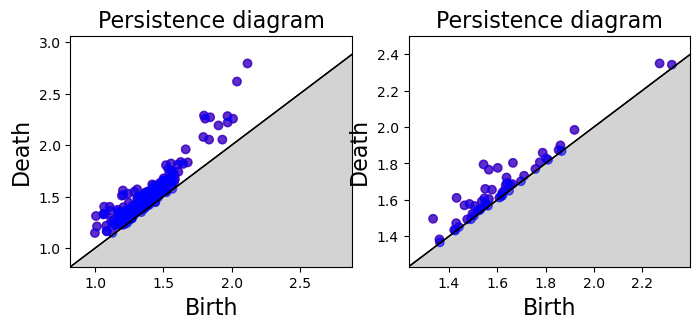

In [64]:
ncols = 2
fig, axes = plt.subplots(nrows=1, ncols= ncols, \
                         figsize=(3 * ncols + 2 , 3))
pd1 = filtLayer.find_persistence_diagrams(all_pts)[1][ind]
pd0 = filtLayer.find_persistence_diagrams(all_pts)[0][ind]
pd1p = filtLayer_new(all_pts)[1][ind]
pd0p = filtLayer_new(all_pts)[0][ind]
gudhi.plot_persistence_diagram(pd1, axes = axes[1])
gudhi.plot_persistence_diagram(pd1p.numpy(), axes = axes[1], colormap = 'blue')


gudhi.plot_persistence_diagram(pd0, axes = axes[0])
gudhi.plot_persistence_diagram(pd0p.numpy(), axes = axes[0], colormap = 'blue')

In [24]:
filtLayer.find_persistence_diagrams(all_pts)[1][ind]

array([[1.36257839, 1.36629891],
       [1.36066675, 1.38279712],
       [1.42618132, 1.43135655],
       [1.42190826, 1.43518114],
       [1.4413985 , 1.45078492],
       [1.43002534, 1.47194958],
       [1.47576714, 1.49296856],
       [1.49114013, 1.49349916],
       [1.33434105, 1.49613178],
       [1.50350356, 1.51254749],
       [1.49737251, 1.52341366],
       [1.52591467, 1.54173017],
       [1.51919353, 1.54468203],
       [1.53178871, 1.55070901],
       [1.5065397 , 1.5662818 ],
       [1.56175971, 1.56707549],
       [1.4643482 , 1.56993556],
       [1.5507071 , 1.56997418],
       [1.4850992 , 1.57775569],
       [1.55120242, 1.58292782],
       [1.53605366, 1.59169126],
       [1.56556964, 1.60440505],
       [1.54664779, 1.60815692],
       [1.43156731, 1.6110574 ],
       [1.60877633, 1.61204541],
       [1.61572325, 1.61927307],
       [1.62150276, 1.62343216],
       [1.62031841, 1.63800526],
       [1.62763894, 1.64882672],
       [1.64910066, 1.65020001],
       [1.